# ICPR 2024 Competition on Multilingual Claim-Span Identification

## Installing Dependencies

In [ ]:
#!pip install --upgrade scikit-learn
#!pip install --upgrade imbalanced-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

### Loading Datasets

In [ ]:
# Training English and Hindi datasets
train_data = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/ML Data/train_en_hi_encoded_labels.json")


# Validation English dataset
val_data_en = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/Clean Data/val_en_encoded_clean.json")

# Validation Hindi dataset
val_data_hi = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/Clean Data/val_hi_encoded_clean.json")

#Test English dataset
test_data_en = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/Test Data/Test Data Clean/test_en_clean.json")

#Test Hindi dataset
test_data_hi = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/Test Data/Test Data Clean/test_hi_clean.json")

In [ ]:
val_data_en.head()

,claims,text_tokens
0,1,listen people the vaccines work they work that...
1,0,i ll take the covid vaccine in 5 years after a...
2,0,@u72240666 hearing that the pope says refusing...
3,1,trump has got the new russian vaccine and he c...
4,1,@u41390182 @u31519664 gotta agree we already i...


In [ ]:
train_data.head()

,claims,text_tokens,labels
0,0,#vaers 17y #pfizer #covidvaccine #suicide atte...,not_claim
1,1,weve truly come a long way from december and j...,claim
2,1,fuck that its not faux outrage inject them wit...,claim
3,1,@u55750420 which makes no sense the vaccine ca...,claim
4,1,fact or fiction you decide the upcoming corona...,claim


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12068 entries, 0 to 12067
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claims       12068 non-null  int64 
 1   text_tokens  12068 non-null  object
 2   labels       12068 non-null  object
dtypes: int64(1), object(2)
memory usage: 283.0+ KB


In [ ]:
val_data_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claims       499 non-null    int64 
 1   text_tokens  499 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


### Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Define pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True))
])

# Apply pipeline on training data
X = pipeline.fit_transform(train_data['text_tokens'])
y = train_data['claims']

# Apply same pipeline on validation data
#X_val = pipeline.transform(val_data['text_tokens'])
#y_val = val_data['claims']


# Apply same pipeline on English validation data
X_val_en = pipeline.transform(val_data_en['text_tokens'])
y_val_en = val_data_en['claims']


# Apply same pipeline on Hindi validation data
X_val_hi = pipeline.transform(val_data_hi['text_tokens'])
y_val_hi = val_data_hi['claims']

# Apply same pipeline on English Test data
X_test_en = pipeline.transform(test_data_en['text_tokens'])
#y_test_en = val_data_en['claims']

# Apply same pipeline on Hindi Test data
X_test_hi = pipeline.transform(test_data_hi['text_tokens'])
#y_test_en = val_data_en['claims']


print("----Training Data------")
print(X.shape)
print(y.shape)

print("\n----English Validation Data------")
print(X_val_en.shape)
print(y_val_en.shape)

print("\n----Hindi Validation Data------")
print(X_val_hi.shape)
print(y_val_hi.shape)

print("\n----English test Data------")
print(test_data_en.shape)
#print(y_val_en.shape)

print("\n----Hindi test Data------")
print(test_data_hi.shape)
#print(y_val_en.shape)

----Training Data------
(12068, 24811)
(12068,)

----English Validation Data------
(499, 24811)
(499,)

----Hindi Validation Data------
(500, 24811)
(500,)

----English test Data------
(1500, 1)

----Hindi test Data------
(1500, 1)


In [ ]:
# Splitting the dataset into the Training set and testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
y_train.value_counts()

claims
1    8830
0    2031
Name: count, dtype: int64

__After checking the training set, there are imbalance of data and it may cause a bias in training the model. Oversampling using `SMOTE` will be used to balance the train dataset.__

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the initial class distribution
print("Initial class distribution:", Counter(y_train))

Initial class distribution: Counter({1: 8830, 0: 2031})


In [ ]:
# Initialize SMOTE with a strategy to balance all classes equally
smote = SMOTE(sampling_strategy='auto', random_state=42)


# Apply SMOTE
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Check the class distribution after SMOTE
print("Resampled class distribution:", Counter(y_train_res))

Resampled class distribution: Counter({1: 8830, 0: 8830})


__Now, the training set is balanced and ready to be feed into the ML models.__

### Model Training & Development

### Logistic Regression Model

In [ ]:
#Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# train a Logistic Regression Model
LR_clf = LogisticRegression(max_iter = 1000) #83
LR_clf.fit(X_train, y_train)

# evaluate the classifier on the test set
LR_pred = LR_clf.predict(X_val_en)
LR_pred_hi = LR_clf.predict(X_val_hi)

In [ ]:
claims = ['not_claim', 'claim']
print('Classification Report for Logistic Regression using English validation dataset :\n',classification_report(y_val_en, LR_pred, target_names=claims))

Classification Report for Logistic Regression using English validation dataset :
               precision    recall  f1-score   support

   not_claim       0.77      0.18      0.30        92
       claim       0.84      0.99      0.91       407

    accuracy                           0.84       499
   macro avg       0.81      0.59      0.60       499
weighted avg       0.83      0.84      0.80       499



In [ ]:
print('Classification Report for Logistic Regression using Hindi validation dataset :\n',classification_report(y_val_hi, LR_pred_hi, target_names=claims))

Classification Report for Logistic Regression using Hindi validation dataset :
               precision    recall  f1-score   support

   not_claim       0.73      0.12      0.21        91
       claim       0.84      0.99      0.91       409

    accuracy                           0.83       500
   macro avg       0.78      0.56      0.56       500
weighted avg       0.82      0.83      0.78       500



In [ ]:
from sklearn.metrics import f1_score, jaccard_score
import numpy as np

# Step 1: Make predictions on the validation set
predictions = (LR_clf.predict(X_val_en) > 0.5).astype(int)

# Initialize lists to hold individual scores
jaccard_scores = []
macro_f1_scores = []

# Iterate over each post
for i in range(len(y_val_en)):
    # Ensure y_val[i] and predictions[i] are arrays
    y_true_post = np.array(y_val_en[i]).reshape(1, -1)
    y_pred_post = np.array(predictions[i]).reshape(1, -1)

    # Calculate Jaccard similarity score for each post
    jaccard = jaccard_score(y_true_post[0], y_pred_post[0], zero_division=0)
    jaccard_scores.append(jaccard)

    # Calculate Macro-F1 score for each post
    macro_f1 = f1_score(y_true_post[0], y_pred_post[0], average='macro', zero_division=0)
    macro_f1_scores.append(macro_f1)

# Calculate the average of the scores
average_jaccard = np.mean(jaccard_scores)
average_macro_f1 = np.mean(macro_f1_scores)

print("Average Jaccard Similarity Score of Logistic Regression using English validation data:", average_jaccard)
print("Average Macro-F1 Score of Logistic Regression using English validation data:", average_macro_f1)

Average Jaccard Similarity Score of Logistic Regression using English validation data: 0.8056112224448898
Average Macro-F1 Score of Logistic Regression using English validation data: 0.8396793587174348


In [ ]:
from sklearn.metrics import f1_score, jaccard_score
import numpy as np

# Step 1: Make predictions on the validation set
predictions = (LR_clf.predict(X_val_hi) > 0.5).astype(int)

# Initialize lists to hold individual scores
jaccard_scores = []
macro_f1_scores = []

# Iterate over each post
for i in range(len(y_val_hi)):
    # Ensure y_val[i] and predictions[i] are arrays
    y_true_post = np.array(y_val_hi[i]).reshape(1, -1)
    y_pred_post = np.array(predictions[i]).reshape(1, -1)

    # Calculate Jaccard similarity score for each post
    jaccard = jaccard_score(y_true_post[0], y_pred_post[0], zero_division=0)
    jaccard_scores.append(jaccard)

    # Calculate Macro-F1 score for each post
    macro_f1 = f1_score(y_true_post[0], y_pred_post[0], average='macro', zero_division=0)
    macro_f1_scores.append(macro_f1)

# Calculate the average of the scores
average_jaccard = np.mean(jaccard_scores)
average_macro_f1 = np.mean(macro_f1_scores)

print("Average Jaccard Similarity Score of Decision Trees using Hindi validation data:", average_jaccard)
print("Average Macro-F1 Score of Decision Trees using Hindi validation data:", average_macro_f1)

Average Jaccard Similarity Score of Decision Trees using Hindi validation data: 0.81
Average Macro-F1 Score of Decision Trees using Hindi validation data: 0.832


## Confusion Matrix for Different Models

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels_dict, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks([0.5 + i for i in range(len(labels_dict))], [labels_dict[i] for i in labels_dict], rotation=45)
    plt.yticks([0.5 + i for i in range(len(labels_dict))], [labels_dict[i] for i in labels_dict])

    plt.title(title)
    plt.show()

label_dict = {
    0: 'not_claim',
    1: 'claim',
}

### Logistic Regression Model

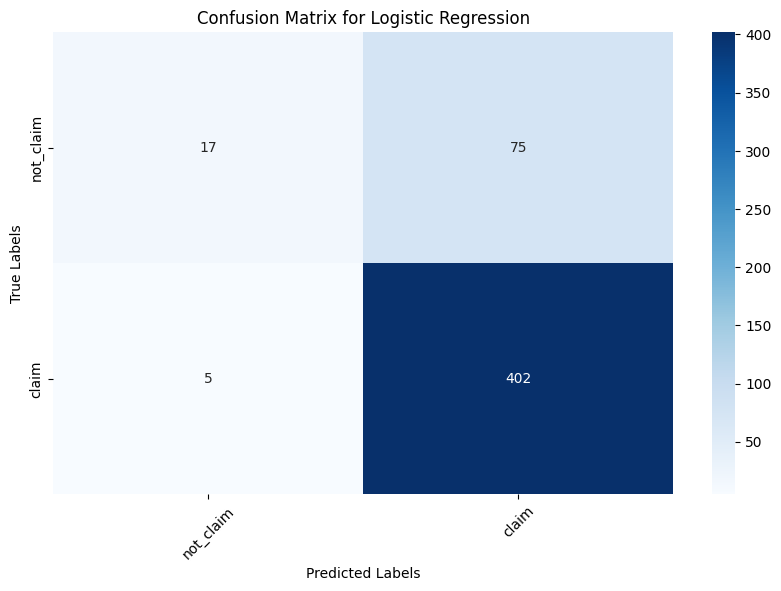

In [ ]:
plot_confusion_matrix(y_val_en, LR_pred, label_dict, title='Confusion Matrix for Logistic Regression')

## Precision-Recall Curve for the trained models

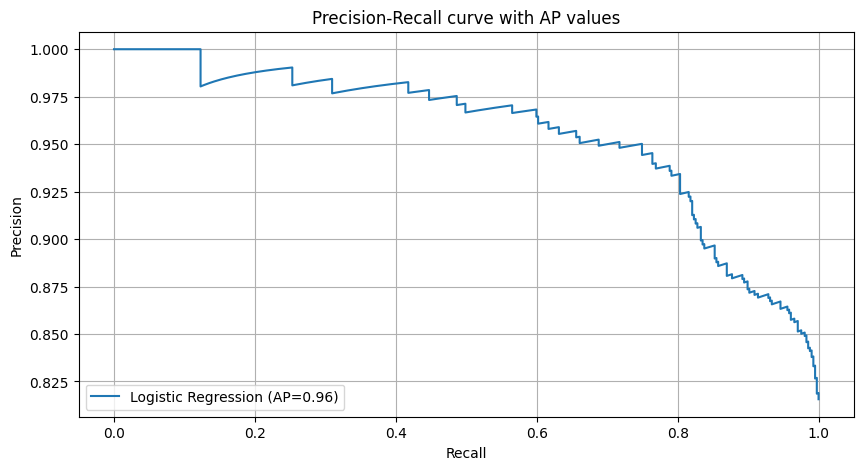

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure that the classifiers are trained and available
classifiers = {
    "Logistic Regression": LR_clf,
}

# Initialize the plot
plt.figure(figsize=(10, 5))

for name, clf in classifiers.items():
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_val_en)[:, 1]
    else:
        y_scores = clf.decision_function(X_val_en)

    precision, recall, _ = precision_recall_curve(y_val_en, y_scores)
    ap = average_precision_score(y_val_en, y_scores)  # Calculate Average Precision (AP)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

# Add legend and title
plt.legend(loc='lower left')
plt.title('Precision-Recall curve with AP values')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

The Precision-Recall (PR) curve is a plot of the precision and recall pairs for different thresholds used in binary classification problems. Here's an explanation of the components and interpretation of the curve:

1. **Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is calculated as TP / (TP + FP), where TP is the number of true positives and FP is the number of false positives. Precision emphasizes the quality of the positive predictions.

2. **Recall (Sensitivity)**: Recall, also known as sensitivity or true positive rate (TPR), is the ratio of correctly predicted positive observations to all actual positives. It is calculated as TP / (TP + FN), where FN is the number of false negatives. Recall emphasizes the coverage of actual positive instances.

3. **Precision-Recall Curve**: The curve is drawn by plotting precision values against recall values for different probability thresholds used to predict the positive class. Each point on the curve represents a different threshold, starting from the highest confidence predictions down to the lowest. A higher area under the curve (AUC) indicates better model performance.

4. **Interpretation**:
   - **Upper right corner**: The ideal position on the curve is the upper right corner, representing perfect precision (1.0) and recall (1.0). This means the classifier has predicted all positives correctly and has made no false positive predictions.
   - **Bottom left corner**: The lower left corner represents the worst case scenario where both precision and recall are close to zero. This indicates poor model performance, where the classifier is making mostly incorrect predictions and missing many positive instances.
   - **Trade-off**: The curve shows the trade-off between precision and recall. In general, as you increase one, the other decreases. A good classifier aims to maximize both precision and recall, but there's often a trade-off depending on the problem's requirements.

In summary, a high AP value indicates good performance, while a low AP value indicates poor performance. However, the interpretation of "high" and "low" can depend on the specific problem and dataset, so it's often useful to compare AP values between different models or against a baseline to gauge relative performance.

### Receiver Operating Characteristic (ROC) Curve for the trained models

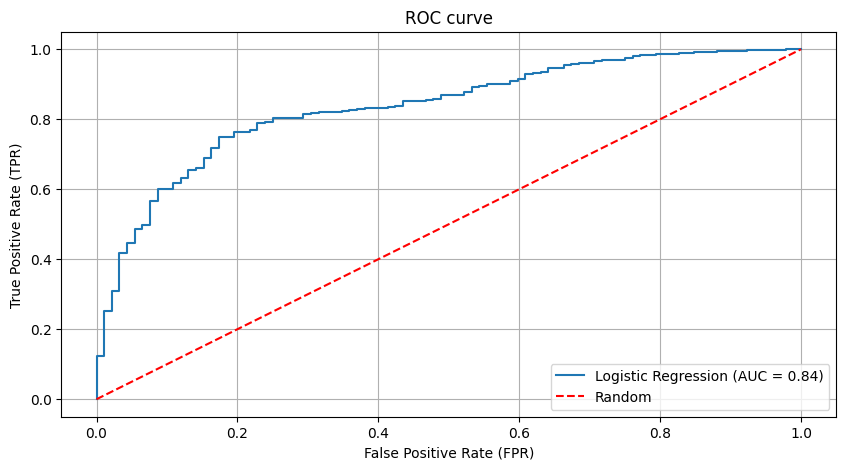

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

plt.figure(figsize=(10, 5))

for name, clf in classifiers.items():
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_val_en)[:, 1]
    else:
        y_scores = clf.decision_function(X_val_en)

    fpr, tpr, _ = roc_curve(y_val_en, y_scores)
    auc_value = roc_auc_score(y_val_en, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid()
plt.show()


The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model at various threshold settings. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for different threshold values. Here's an explanation of the key components:

1. **True Positive Rate (TPR)**: This is also known as sensitivity or recall. It is the ratio of correctly predicted positive observations to all actual positives. TPR = TP / (TP + FN), where TP is True Positives and FN is False Negatives. TPR tells us how good the model is at predicting positive classes.

2. **False Positive Rate (FPR)**: This is the ratio of incorrectly predicted negative observations to all actual negatives. FPR = FP / (FP + TN), where FP is False Positives and TN is True Negatives. FPR tells us how often the model makes a mistake and predicts a positive outcome when the actual outcome was negative.

3. **Random Guess Line**: The diagonal line from (0,0) to (1,1) represents the ROC curve for a random classifier. Points above this line represent good models, as they have better TPR than FPR.

4. **ROC Curve**: The ROC curve shows the trade-off between sensitivity (TPR) and specificity (1 - FPR) as the threshold for classifying positive instances is varied. A perfect classifier would have its curve passing through the top-left corner (TPR=1, FPR=0), indicating high TPR and low FPR.

5. **Area Under the Curve (AUC)**: The area under the ROC curve quantifies the overall performance of the model across all possible classification thresholds. A higher AUC value indicates a better model.

In summary, the ROC curve helps us visualize and assess the performance of a binary classification model, especially in terms of its ability to discriminate between positive and negative classes.

In [ ]:
test_data_en["target"] = LR_clf.predict(X_test_en)
test_data_hi["target"] = LR_clf.predict(X_test_hi)

In [ ]:
test_data_en.head()

,text_tokens,target
0,@u20719141 @u55524931 we have to assume no vac...,1
1,@u41101034 same as my union screaming out for ...,1
2,this is why i laff talked all that shit went a...,1
3,@u21887764 ugh that is tragic i have a cousin ...,1
4,@u40601807 @u69515872 heroes the direction tho...,1


In [ ]:
test_data_hi.head()

,text_tokens,target
0,एक नचनिया के अवैध निर्माण पर कार्रवाई से बीजेप...,1
1,अब चुमार में घुसपैठ की कोशिश नाकाम भारत बोला स...,1
2,RT @ U64277340 ड्रग्स भी लेती थीं बीफ भी खाती ...,0
3,अनलॉक 4 में रेलवे चला सकता है 100 नई ट्रेनें इ...,1
4,अभी तक आरोपी लाखों लीटर ऑयल चुरा चुके हैं @ U1...,1


In [ ]:
import json
import pandas as pd

# Make Predictions
predictions_en = LR_clf.predict(X_test_en)
predictions_hi = LR_clf.predict(X_test_hi)

# Read the JSON data
sub_en_data = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/Test Data/test-en.json")
sub_hi_data = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/Test Data/test-hi.json")

# Example test data for tokenization demonstration
test_data_en = sub_en_data.text_tokens.tolist()
test_data_hi = sub_hi_data.text_tokens.tolist()

# Ensure the text tokens are lists of lists
tokenized_en = [tokens.split() if isinstance(tokens, str) else tokens for tokens in test_data_en]
tokenized_hi = [tokens.split() if isinstance(tokens, str) else tokens for tokens in test_data_hi]

# Helper function to map predictions to binary arrays with correct length
def create_binary_arrays(predictions, tokenized_data):
    binary_arrays = []
    for pred, tokens in zip(predictions, tokenized_data):
        length = len(tokens)
        binary_array = [1 if pred == 1 else 0] * length
        binary_arrays.append(binary_array[:length])  # Ensure the correct length
    return binary_arrays

# Create binary arrays for English and Hindi predictions
binary_arrays_en = create_binary_arrays(predictions_en, tokenized_en)
binary_arrays_hi = create_binary_arrays(predictions_hi, tokenized_hi)

# Add the binary arrays as a new column to the DataFrames
sub_en_data['prediction'] = binary_arrays_en
sub_hi_data['prediction'] = binary_arrays_hi

# Save the DataFrames to JSON files
sub_en_data.to_json("en_preds.json", orient='records', lines=True)
sub_hi_data.to_json("hi_preds.json", orient='records', lines=True)


In [ ]:
test = pd.read_json("/content/en_preds.json",lines=True)
test.head()

,index,text_tokens,prediction
0,6499,"[@U20719141, @U55524931, We, have, to, assume,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,6500,"[@U41101034, Same, as, my, union, ,, screaming...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,6501,"[This, is, why, i, Laff, Talked, all, that, sh...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,6502,"[@U21887764, Ugh, ..., that, is, tragic, ., I,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,6503,"[@U40601807, @U69515872, Heroes, the, directio...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
test1 = pd.read_json("/content/hi_preds.json",lines=True)
test1.head()

,index,text_tokens,prediction
0,6598,"[एक, नचनिया, के, अवैध, निर्माण, पर, कार्रवाई, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,6599,"[अब, चुमार, में, घुसपैठ, की, कोशिश, नाकाम, ,, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,6600,"[RT, @U64277340, :, ड्रग्स, भी, लेती, थीं, बीफ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6601,"[अनलॉक, -, 4, में, रेलवे, चला, सकता, है, 100, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,6602,"[अभी, तक, आरोपी, लाखों, लीटर, ऑयल, चुरा, चुके,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
